CNN 구조를 사용하여 autoencoder 를 만들어봅시다

Using TensorFlow backend.


train_images <class 'numpy.ndarray'> (60000, 28, 28) uint8
test_images <class 'numpy.ndarray'> (10000, 28, 28) uint8


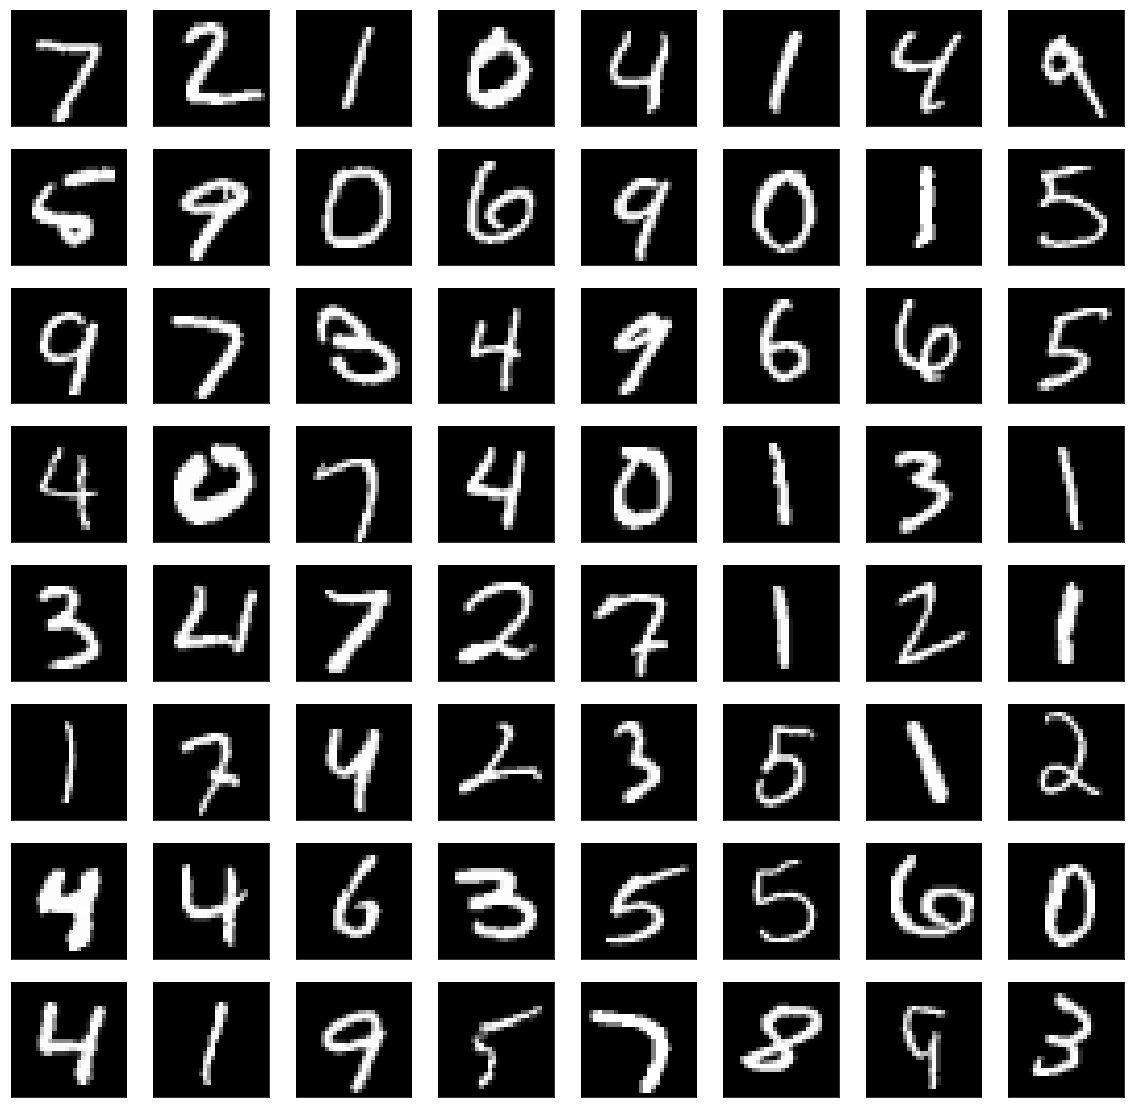

In [0]:
from keras import datasets, layers, models, utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(train_images, _), (test_images, _) = datasets.mnist.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )
print( 'test_images', type(test_images), test_images.shape, test_images.dtype )

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( test_images[i], cmap="gray" )

다음과 같이 입력 데이터의 전처리를 해줍니다.

In [0]:
_, H, W = train_images.shape
train_x = ( train_images.reshape(-1, H, W, 1) / 255 ).astype('float32')
test_x = ( test_images.reshape(-1, H, W, 1) / 255 ).astype('float32')
print( 'test_x', type(test_x), test_x.shape, test_x.dtype )

test_x <class 'numpy.ndarray'> (10000, 28, 28, 1) float32


인코더, 디코더, 그 둘을 합쳐 오토 인코더를 만듭니다. 출력을 0~1 로 한정짓기 위해서 마지막 층에 sigmoid 활성함수를 사용했습니다. loss 함수로 mse 를 사용해도 되지만 필기체 이미지의 픽셀값들이 0 이나 1 에 가까운 값들기 많기 때문에 binary_crossentropy 를 사용했습니다.

In [0]:
x = layers.Input(shape=(H,W,1), name='x')
e = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='e1')(x)
e = layers.MaxPooling2D((2, 2), name='e2')(e)
e = layers.Conv2D(8, (3,3), padding='same', activation='relu', name='e3')(e)
e = layers.MaxPooling2D((2, 2), name='e4')(e)
e = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='e5')(e)
z = layers.Conv2D(1, (3,3), padding='same', activation='relu', name='z')(e)
encoder = models.Model(x, z)
        
z = layers.Input(shape=encoder.get_layer('z').output_shape[1:], name = 'z')
d = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='d1')(z)
d = layers.UpSampling2D((2, 2), name='d2')(d)
d = layers.Conv2D(8, (3,3), padding='same', activation='relu', name='d3')(d)
d = layers.UpSampling2D((2, 2), name='d4')(d)
d = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='d5')(d)
y = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid', name='y')(d)
decoder = models.Model(z, y)

autoencoder = models.Sequential()
autoencoder.add( encoder )
autoencoder.add( decoder )

encoder.summary()
decoder.summary()
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 28, 28, 1)         0         
_________________________________________________________________
e1 (Conv2D)                  (None, 28, 28, 4)         40        
_________________________________________________________________
e2 (MaxPooling2D)            (None, 14, 14, 4)         0         
_________________________________________________________________
e3 (Conv2D)                  (None, 14, 14, 8)         296       
_________________________________________________________________
e4 (MaxPooling2D)            (None, 7, 7, 8)           0         
_________________________________________________________________
e5 (Conv2D)                  (None, 7, 7, 4)           292       
_________________________________________________________________
z (Conv2D)                   (None, 7, 7, 1)           37        
Total para

모델을 학습하고 검증합니다.

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 6s 104us/step - loss: 0.3837 - acc: 0.8049 - val_loss: 0.1493 - val_acc: 0.8013
Epoch 2/20
54000/54000 [==============================] - 3s 54us/step - loss: 0.1201 - acc: 0.8081 - val_loss: 0.1098 - val_acc: 0.8110
Epoch 3/20
54000/54000 [==============================] - 3s 54us/step - loss: 0.1060 - acc: 0.8109 - val_loss: 0.1048 - val_acc: 0.8108
Epoch 4/20
54000/54000 [==============================] - 3s 53us/step - loss: 0.1022 - acc: 0.8115 - val_loss: 0.1022 - val_acc: 0.8122
Epoch 5/20
54000/54000 [==============================] - 3s 53us/step - loss: 0.1001 - acc: 0.8118 - val_loss: 0.1008 - val_acc: 0.8126
Epoch 6/20
54000/54000 [==============================] - 3s 53us/step - loss: 0.0988 - acc: 0.8121 - val_loss: 0.0993 - val_acc: 0.8126
Epoch 7/20
54000/54000 [==============================] - 3s 53us/step - loss: 0.0977 - acc: 0.8123 - val_loss: 0.0984 - val_acc

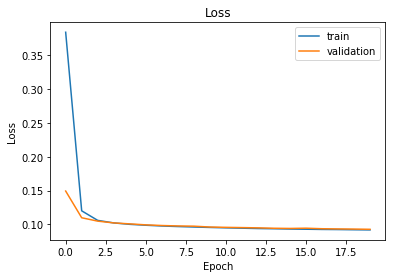

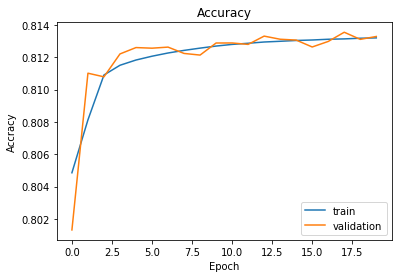

10000/10000 [==============================] - 0s 20us/step
[loss, accuracy] = [0.09072516833543777, 0.8122323987960816]


In [0]:
hist = autoencoder.fit(train_x, train_x, epochs=20, batch_size=128, validation_split=0.1)

from modules.plot_history import plot_loss, plot_acc
plot_loss(hist, 'Loss')
plt.show()
plot_acc(hist, 'Accuracy')
plt.show()

performance_test = autoencoder.evaluate(test_x, test_x, batch_size=128)
print( '[loss, accuracy] =', performance_test )

입력이미지를 인코딩하고 그 인코딩 된 값을 디코딩하여 원래 이미지와 비슷하게 복원되는지 확인합시다.

encoded_imgs.shape = (10000, 7, 7, 1)
decoded_imgs.shape = (10000, 28, 28, 1)


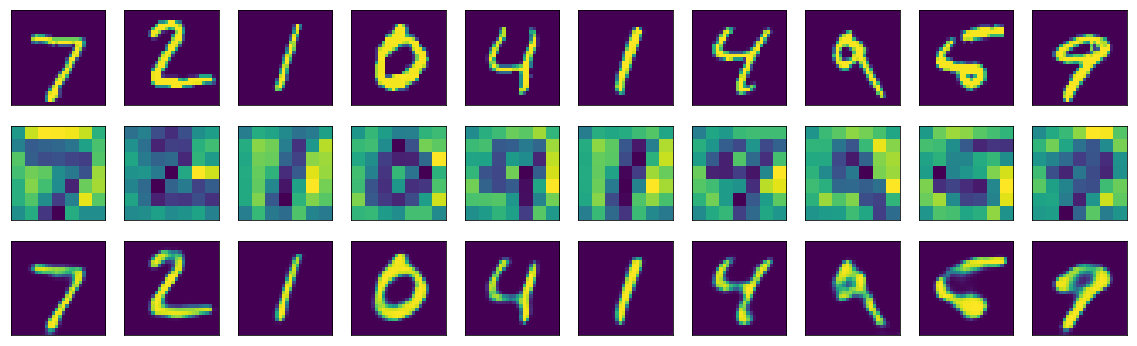

In [0]:
encoded_imgs = encoder.predict(test_x)
decoded_imgs = decoder.predict(encoded_imgs)

print( 'encoded_imgs.shape =', encoded_imgs.shape )
print( 'decoded_imgs.shape =', decoded_imgs.shape )

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(test_x[i].reshape(28, 28))

    plt.subplot(3, n, i + 1 + n)
    plt.xticks([]); plt.yticks([])
    plt.imshow(encoded_imgs[i].reshape(7,7))

    plt.subplot(3, n, i + 1 + n + n)
    plt.xticks([]); plt.yticks([])
    plt.imshow(decoded_imgs[i].reshape(28, 28))

plt.show()

노이즈가 첨가된 입력 이미지가 들어가면 노이즈가 제거가 되는 이미지가 출력되는것을 알 수 있습니다.

encoded_imgs.shape = (10000, 7, 7, 1)
decoded_imgs.shape = (10000, 28, 28, 1)


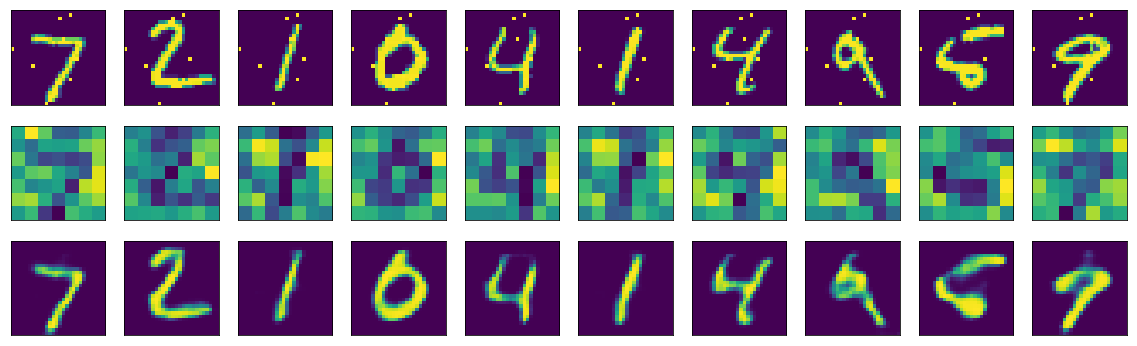

In [0]:
noise = np.zeros((H,W,1), dtype=np.float32)
num_noise_points = 8
noise_posx = np.random.randint(0, W, num_noise_points)
noise_posy = np.random.randint(0, H, num_noise_points)
for i in range(num_noise_points):
    noise[noise_posy[i], noise_posx[i], 0] = 1

test_x_noise = np.clip(test_x + noise, 0, 1)

encoded_imgs = encoder.predict(test_x_noise)
decoded_imgs = decoder.predict(encoded_imgs)

print( 'encoded_imgs.shape =', encoded_imgs.shape )
print( 'decoded_imgs.shape =', decoded_imgs.shape )

plt.figure(figsize=(20, 6))

for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(test_x_noise[i].reshape(28, 28))

    plt.subplot(3, n, i + 1 + n)
    plt.xticks([]); plt.yticks([])
    plt.imshow(encoded_imgs[i].reshape(7,7))

    plt.subplot(3, n, i + 1 + n + n)
    plt.xticks([]); plt.yticks([])
    plt.imshow(decoded_imgs[i].reshape(28, 28))

plt.show()